In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn import svm
import seaborn as sns

In [6]:
seed = 42

## improve speed by limiting max columns shown at once
pd.set_option('display.max_columns', 50)

### Merge the match data from 2000-2020

In [7]:
frames = []

# Add games from years 2000-2020
for year in range(2000, 2021):
    frames.append(pd.read_csv(f"./data/matches_{year}.csv"))

df = pd.concat(frames)

### Clean up the data

In [8]:
## irrelevant columns
irr_cols = []
player_cols = ["ace", "df", "svpt", "1stIn", "1stWon", "2ndWon", "SvGms", "bpSaved", "bpFaced"]
general_cols = ["winner_name", "tourney_name", "loser_name", "winner_ioc", "loser_ioc", "minutes", "score", "draw_size", "round", "loser_seed", "loser_entry", "loser_rank_points", "winner_rank_points", "winner_seed", "winner_entry", "match_num", "tourney_id", "tourney_level", "best_of"]
## add winner/loser cols
for el in player_cols:
    irr_cols.append(f"w_{el}")
    irr_cols.append(f"l_{el}")

## add the general cols
irr_cols.extend(general_cols)

## drop irrelevant cols
df.drop(columns=irr_cols, inplace=True)

## calculate mean height of the players and replace null values with it
mean_ht = (df["winner_ht"].mean() + df["loser_ht"].mean()) / 2
df.loc[df["winner_ht"].isnull(), "winner_ht"] = mean_ht
df.loc[df["loser_ht"].isnull(), "loser_ht"] = mean_ht

## drop empty values
df.dropna(axis=0, inplace=True)

### Convert numerical values to floats

In [9]:
numeric_cols = ["winner_rank", "loser_rank", "winner_age", "loser_age", "winner_ht", "loser_ht"]
df[numeric_cols] = df[numeric_cols].astype(float)

### Adjust the dataset for performing predictions

In [10]:
## replace winner/loser with player1 & 2
for (colName, colData) in df.iteritems():
    if "winner" in colName:
        endingVal = colName.split("_")[1]
        df.rename(columns={colName: f"player1_{endingVal}"}, inplace=True)
    elif "loser" in colName:
        endingVal = colName.split("_")[1]
        df.rename(columns={colName: f"player2_{endingVal}"}, inplace=True)


## swap the labels for half of the values

first_half, second_half = df[:int(len(df) / 2)], df[int(len(df) / 2):]
first_half.insert(loc=0, column="label", value=1)

## swap columns
scols = list(second_half.columns)

np.warnings.filterwarnings('ignore')

## swap the columns for the second half
for attr in ["id", "hand", "ht", "age", "rank"]:
    scols[scols.index(f"player1_{attr}")], scols[scols.index(f"player2_{attr}")] = scols[scols.index(f"player2_{attr}")], scols[scols.index(f"player1_{attr}")]
    # second_half.insert(loc=0, column="label", value=0)
    second_half["label"] = 0

halves = []

df = pd.concat([first_half, second_half])


### Visualize data

AttributeError: 'Rectangle' object has no property 'density'

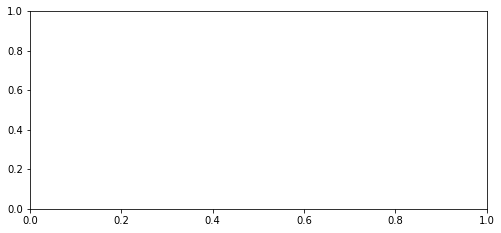

In [42]:
cols = ["player1_rank", "player2_rank", "player1_age", "player2_age"]


plt.figure(1, figsize=(18, 8))

for i in range(len(cols)):
    plt.subplot(2, 2, i + 1)
    df[cols[i]].plot(kind="bar", density=True, title=cols[i])

plt.show()

### Prepare data for ML models

In [239]:
## convert categorical values (player hand, surface) to numbers
le = LabelEncoder()
df["surface"] = le.fit_transform(df["surface"])
df["player1_hand"] = le.fit_transform(df["player1_hand"])
df["player2_hand"] = le.fit_transform(df["player2_hand"])

## features that will be used in the model
features = ["player1_ht", "player2_ht", "player1_age", "player2_age", "player1_rank", "player2_rank", "surface", "player1_hand", "player2_hand"]
X = df[features]
y = df["label"]

kf = KFold(n_splits=3, shuffle=True, random_state=seed)

### Logistic Regression

In [253]:
train_err_sum, val_err_sum, train_acc_sum, val_acc_sum, precision_sum = 0, 0, 0, 0, 0

for train_indices, val_indices in kf.split(X):
    X_train, X_val, y_train, y_val = X.iloc[train_indices], X.iloc[val_indices], y.iloc[train_indices], y.iloc[val_indices]

    clf_1 = LogisticRegression()

    ## training the model
    clf_1.fit(X_train, y_train)
    y_pred_train_1 = clf_1.predict(X_train)
    acc_train_1 = clf_1.score(X_train, y_train)
    accuracy_1 = clf_1.score(X, y)

    ## validation
    y_pred_val_1 = clf_1.predict(X_val)
    acc_val_1 = clf_1.score(X_val, y_val)


    ## confusion matrix
    conf_mat = confusion_matrix(y, np.concatenate([y_pred_train_1, y_pred_val_1]))

    ## calculate the precision by dividing TP by (TP + FP)
    ## it denotes the proportion of true positives in total positives
    true_pos = conf_mat[1][1]
    false_pos = conf_mat[0][1]
    precision = true_pos / (true_pos + false_pos)

    ## errors
    err_train = log_loss(y_train, y_pred_train_1)
    err_val = log_loss(y_val, y_pred_val_1)

    train_err_sum += err_train
    val_err_sum += err_val
    train_acc_sum += acc_train_1
    val_acc_sum += acc_val_1
    precision_sum += precision

    print(f"training accuracy: {acc_train_1}")
    print(f"validation accuracy: {acc_val_1}")
    print(f"precision: {precision}")
    print(f"training error: {err_train}")
    print(f"validation error: {err_val}")
    print("--------------")


n = kf.get_n_splits()

print("total results:")
print(f"\taverage training accuracy: {train_acc_sum/n}")
print(f"\taverage validation accuracy: {val_acc_sum/n}")
print(f"\taverage precision: {precision_sum/n}")
print(f"\taverage training error: {train_err_sum/n}")
print(f"\taverage validation error: {val_err_sum/n}")

training accuracy: 0.6059975668282059
validation accuracy: 0.6066529100600228
precision: 0.54646239908461
training error: 13.608530672524596
validation error: 13.585896416317375
--------------
training accuracy: 0.6061420784126579
validation accuracy: 0.6059673202175068
precision: 0.5476622806640103
training error: 13.603536457890108
validation error: 13.609572367930502
--------------
training accuracy: 0.6054497671010977
validation accuracy: 0.6055304247296289
precision: 0.5481662760534687
training error: 13.627447922550193
validation error: 13.624661241464239
--------------
total results:
	average training accuracy: 0.6058631374473206
	average validation accuracy: 0.6060502183357195
	average precision: 0.5474303186006964
	average training error: 13.613171684321633
	average validation error: 13.606710008570706
